# Ray RLlib - Explore RLlib - Sample Application: CartPole

© 2019-2022, Anyscale. All Rights Reserved

![Anyscale Academy](../../images/AnyscaleAcademyLogo.png)

We were briefly introduced to the `CartPole` example and the OpenAI gym `CartPole-v1` environment ([gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)) in the [reinforcement learning introduction](../01-Introduction-to-Reinforcement-Learning.ipynb). This lesson uses [RLlib](https://ray.readthedocs.io/en/latest/rllib.html) to train a policy for `CartPole`.

Recall that the `gym` Python module provides MDP interfaces to a variety of simulators, like the simple simulator for the physics of balancing a pole on a cart that is used by the CartPole environment. The `CartPole` problem is described at https://gym.openai.com/envs/CartPole-v1.

![Cart Pole](../../images/rllib/Cart-Pole.png)

([source](https://gym.openai.com/envs/CartPole-v1/))

Even though this is a relatively simple and quick example to run, its results can be understood quite visually. `CartPole` is one of OpenAI Gym's ["classic control"](https://gym.openai.com/envs/#classic_control) examples.

For more background about this problem, see:

* ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077), AG Barto, RS Sutton, and CW Anderson, *IEEE Transactions on Systems, Man, and Cybernetics* (1983). The same Sutton and Barto who wrote [*Reinforcement Learning: An Introduction*](https://mitpress.mit.edu/books/reinforcement-learning-second-edition).
* ["Cartpole - Introduction to Reinforcement Learning (DQN - Deep Q-Learning)"](https://towardsdatascience.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288), [Greg Surma](https://twitter.com/GSurma).

First, import Ray and the PPO module in RLlib, then start Ray.

In [1]:
import ray
import ray.rllib.agents.ppo as ppo

In [2]:
import pandas as pd
import json
import os
import shutil
import sys

Model *checkpoints* will get saved after each iteration into directories under `tmp/ppo/cart`, i.e., relative to this directory. 
The default directories for checkpoints are `$HOME/ray_results/<algo_env>/.../checkpoint_N`.

> **Note:** If you prefer to use a different directory root, change it in the next cell _and_ in the `rllib rollout` command below.

In [3]:
checkpoint_root = "tmp/ppo/cart"

Clean up output of previous lessons (optional):

In [4]:
# Where checkpoints are written:
shutil.rmtree(checkpoint_root, ignore_errors=True, onerror=None)

# Where some data will be written and used by Tensorboard below:
ray_results = f'{os.getenv("HOME")}/ray_results/'
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

Start Ray:

In [5]:
info = ray.init(ignore_reinit_error=True)

2022-03-17 16:35:23,827	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265


The Ray Dashboard is useful for monitoring Ray:

In [6]:
print("Dashboard URL: http://{}".format(info["webui_url"]))

Dashboard URL: http://127.0.0.1:8265


Next we'll train an RLlib policy with the [`CartPole-v1` environment](https://gym.openai.com/envs/CartPole-v1/).

If you've gone through the _Multi-Armed Bandits_ lessons, you may recall that we used [Ray Tune](http://tune.io), the Ray Hyperparameter Tuning system, to drive training. Here we'll do it ourselves.

By default, training runs for `10` iterations. Increase the `N_ITER` setting if you want to train longer and see the resulting rewards improve. However, if the max score of `200` is achieved early, you can use a smaller number of iterations.


- `num_workers` is the number of actors that the agent will create. This determines the degree of parallelism that will be used. In a cluster, these actors will be spread over the available nodes.
- `num_sgd_iter` is the number of epochs of SGD (stochastic gradient descent, i.e., passes through the data) that will be used to optimize the PPO surrogate objective at each iteration of PPO, for each _minibatch_ ("chunk") of training data. Using minibatches is more efficient than training with one record at a time.
- `sgd_minibatch_size` is the SGD minibatch size (batches of data) that will be used to optimize the PPO surrogate objective.
- `model` contains a dictionary of parameters describing the neural net used to parameterize the policy. The `fcnet_hiddens` parameter is a list of the sizes of the hidden layers. Here, we have two hidden layers of size 100, each.
- `num_cpus_per_worker` when set to 0 prevents Ray from pinning a CPU core to each worker, which means we could run out of workers in a constrained environment like a laptop or a cloud VM.

> **Note:** If you change the values shown for `config['model']['fcnet_hiddens']`, make the same change in the `rllib rollout` command below!

In [7]:
SELECT_ENV = "CartPole-v1"                      # Specifies the OpenAI Gym environment for Cart Pole
N_ITER = 10                                     # Number of training runs.

config = ppo.DEFAULT_CONFIG.copy()              # PPO's default configuration. See the next code cell.
config["log_level"] = "WARN"                    # Suppress too many messages, but try "INFO" to see what can be printed.

# Other settings we might adjust:
config["num_workers"] = 1                       # Use > 1 for using more CPU cores, including over a cluster
config["num_sgd_iter"] = 10                     # Number of SGD (stochastic gradient descent) iterations per training minibatch.
                                                # I.e., for each minibatch of data, do this many passes over it to train. 
config["sgd_minibatch_size"] = 250              # The amount of data records per minibatch
config["model"]["fcnet_hiddens"] = [100, 50]    #
config["num_cpus_per_worker"] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed

Out of curiousity, let's see what configuration settings are defined for PPO. Note in particular the parameters for the deep learning `model`:

In [8]:
ppo.DEFAULT_CONFIG

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 5e-05,
 'train_batch_size': 4000,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  '_disable_action_flattening': False,
  'fcnet_hiddens': [100, 50],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,


In [9]:
agent = ppo.PPOTrainer(config, env=SELECT_ENV)

results = []
episode_data = []
episode_json = []

for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    
    episode = {'n': n, 
               'episode_reward_min': result['episode_reward_min'], 
               'episode_reward_mean': result['episode_reward_mean'], 
               'episode_reward_max': result['episode_reward_max'],  
               'episode_len_mean': result['episode_len_mean']}
    
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    file_name = agent.save(checkpoint_root)
    
    print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}')

2022-03-17 16:35:36,457	INFO trainer.py:2140 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-03-17 16:35:36,461	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-03-17 16:35:36,462	INFO trainer.py:779 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-03-17 16:35:44,506	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
2022-03-17 16:35:44,967	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise 

  0: Min/Mean/Max reward:   9.0000/ 21.2553/ 74.0000. Checkpoint saved to tmp/ppo/cart/checkpoint_000001/checkpoint-1
  1: Min/Mean/Max reward:  10.0000/ 29.7594/ 87.0000. Checkpoint saved to tmp/ppo/cart/checkpoint_000002/checkpoint-2
  2: Min/Mean/Max reward:  12.0000/ 40.4000/123.0000. Checkpoint saved to tmp/ppo/cart/checkpoint_000003/checkpoint-3
  3: Min/Mean/Max reward:  13.0000/ 55.6100/163.0000. Checkpoint saved to tmp/ppo/cart/checkpoint_000004/checkpoint-4
  4: Min/Mean/Max reward:  13.0000/ 67.5600/169.0000. Checkpoint saved to tmp/ppo/cart/checkpoint_000005/checkpoint-5
  5: Min/Mean/Max reward:  21.0000/ 86.5800/220.0000. Checkpoint saved to tmp/ppo/cart/checkpoint_000006/checkpoint-6
  6: Min/Mean/Max reward:  23.0000/115.5200/412.0000. Checkpoint saved to tmp/ppo/cart/checkpoint_000007/checkpoint-7
  7: Min/Mean/Max reward:  33.0000/139.7600/500.0000. Checkpoint saved to tmp/ppo/cart/checkpoint_000008/checkpoint-8
  8: Min/Mean/Max reward:  42.0000/166.6600/500.0000. Ch

The episode rewards should increase after multiple iterations. Try tweaking the config parameters. Smaller values for the `num_sgd_iter`, `sgd_minibatch_size`, or the `model`'s `fcnet_hiddens` will train faster, but take longer to improve the policy.

In [10]:
df = pd.DataFrame(data=episode_data)
df

,n,episode_reward_min,episode_reward_mean,episode_reward_max,episode_len_mean
0,0,9.0,21.255319,74.0,21.255319
1,1,10.0,29.759398,87.0,29.759398
2,2,12.0,40.400000,123.0,40.400000
3,3,13.0,55.610000,163.0,55.610000
4,4,13.0,67.560000,169.0,67.560000
5,5,21.0,86.580000,220.0,86.580000
6,6,23.0,115.520000,412.0,115.520000
7,7,33.0,139.760000,500.0,139.760000
8,8,42.0,166.660000,500.0,166.660000
9,9,49.0,195.630000,500.0,195.630000


<AxesSubplot:>

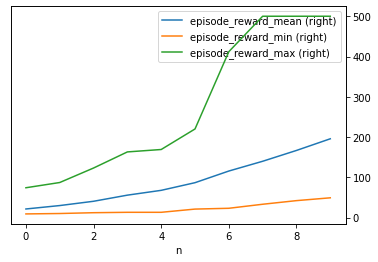

In [12]:
df.plot(x="n", y=["episode_reward_mean", "episode_reward_min", "episode_reward_max"], secondary_y=True)

Also, print out the policy and model to see the results of training in detail…

In [13]:
import pprint

policy = agent.get_policy()
model = policy.model

pprint.pprint(model.variables())
pprint.pprint(model.value_function())

print(model.base_model.summary())

[<tf.Variable 'default_policy/fc_1/kernel:0' shape=(4, 100) dtype=float32>,
 <tf.Variable 'default_policy/fc_1/bias:0' shape=(100,) dtype=float32>,
 <tf.Variable 'default_policy/fc_value_1/kernel:0' shape=(4, 100) dtype=float32>,
 <tf.Variable 'default_policy/fc_value_1/bias:0' shape=(100,) dtype=float32>,
 <tf.Variable 'default_policy/fc_2/kernel:0' shape=(100, 50) dtype=float32>,
 <tf.Variable 'default_policy/fc_2/bias:0' shape=(50,) dtype=float32>,
 <tf.Variable 'default_policy/fc_value_2/kernel:0' shape=(100, 50) dtype=float32>,
 <tf.Variable 'default_policy/fc_value_2/bias:0' shape=(50,) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/kernel:0' shape=(50, 2) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/bias:0' shape=(2,) dtype=float32>,
 <tf.Variable 'default_policy/value_out/kernel:0' shape=(50, 1) dtype=float32>,
 <tf.Variable 'default_policy/value_out/bias:0' shape=(1,) dtype=float32>]
<tf.Tensor 'Reshape:0' shape=(?,) dtype=float32>
Model: "model"
________________

## Rollout

Next we'll use the [RLlib rollout CLI](https://ray.readthedocs.io/en/latest/rllib-training.html#evaluating-trained-policies), to evaluate the trained policy.

This visualizes the `CartPole` agent operating within the simulation: moving the cart left or right to avoid having the pole fall over.

We'll use the last saved checkpoint, `checkpoint_10` (or whatever you set for `N_ITER` above) for the rollout, evaluated through `2000` steps.

> **Notes:** 
>
> 1. If you changed `checkpoint_root` above to be different than `tmp/ppo/cart`, then change it here, too. Note that bugs in variable substitution in Jupyter notebooks, we can't use variables in the next cell, unfortunately.
> 2. If you changed the model parameters, specifically the `fcnet_hiddens` array in the `config` object above, make the same change here.

You may need to make one more modification, depending on how you are running this tutorial:

1. Running on your laptop? - Remove the line `--no-render`. 
2. Running on the Anyscale Service? The popup windows that would normally be created by the rollout can't be viewed in this case. Hence, the `--no-render` flag suppresses them. The code cell afterwords provides a sample video. You can try adding `--video-dir tmp/ppo/cart`, which will generate MP4 videos, then download them to view them. Or copy the `Video` cell below and use it to view the movies.

In [ ]:
!rllib evaluate tmp/ppo/cart/checkpoint_10/checkpoint-10 \
    --config "{\"env\": \"CartPole-v1\", \"model\": {\"fcnet_hiddens\": [100, 50]}}" \
    --run PPO \
    --no-render \
    --steps 2000

Here is a sample episode. 

> **Note:** This video was created by running the previous `rllib rollout` command with the argument `--video-dir some_directory`. It creates one video per episode.

In [ ]:
from IPython.display import Video

cart_pole_sample_video = "../../images/rllib/Cart-Pole-Example-Video.mp4"
Video(cart_pole_sample_video)

Finally, launch [TensorBoard](https://ray.readthedocs.io/en/latest/rllib-training.html#getting-started) as discussed in [02 Introduction to RLlib](../02-Introduction-to-RLlib.ipynb). Select the Cart Pole runs and visualize the key metrics from training with RLlib.

```shell
tensorboard --logdir=$HOME/ray_results
```

For more examples of working with Gym environments, go through the next lesson, [Bipedal Walker](02-Bipedal-Walker.ipynb), then any of the "extra" lessons:

* [Extras: Application - Mountain Car](extras/Extra-Application-Mountain-Car.ipynb) -- Based on the `MountainCar-v0` environment from OpenAI Gym.
* [Extras: Application - Taxi](extras/Extra-Application-Taxi.ipynb) -- Based on the `Taxi-v3` environment from OpenAI Gym.
* [Extras: Application - Frozen Lake](extras/Extra-Application-Frozen-Lake.ipynb) -- Based on the `FrozenLake-v0` environment from OpenAI Gym.

Use TensorBoard to visualize their training runs, metrics, etc., as well. (These notebooks won't mention this suggestion.)

## Exercise ("Homework")

In addition to _Cart Pole_, _Bipedal Walker_, and _Mountain Car_, there are other so-called ["classic control"](https://gym.openai.com/envs/#classic_control) examples you can try. Make a copy of this notebook and edit as required.

In [16]:
ray.shutdown()